In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [3]:
params = {
    'batch_size': 128, #size of the batches
    'image_size': 32, #size of each image dimension
    'lr': 0.0001, #adam: learning rate
    'b1': 0.5, #adam: decay of first order momentum of gradient
    'b2': 0.999, #adam: decay of first order momentum of gradient
}

In [4]:
transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(params['image_size']),
    transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

trainset = datasets.MNIST(root='./data', train='train',
                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], pin_memory=True,
                                          shuffle=True)
print(len(trainloader[0]))

testset = datasets.MNIST(root='./data', train=False,
                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], pin_memory=True,
                                         shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

0it [00:00, ?it/s]

100%|█████████▉| 9895936/9912422 [00:18<00:00, 435091.61it/s] 
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



 57%|█████▋    | 16384/28881 [00:00<00:00, 72760.68it/s]
32768it [00:00, 47780.49it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



 99%|█████████▉| 1630208/1648877 [00:05<00:00, 454904.91it/s]

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 17862.49it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


TypeError: 'DataLoader' object is not subscriptable

9920512it [00:30, 435091.61it/s]                             
1654784it [00:20, 454904.91it/s]                             

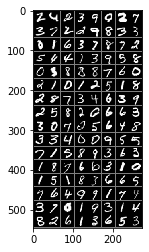

    2     4     2     3


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], pin_memory=True,
                                          shuffle=True)


In [37]:
np.size(list(enumerate(trainloader))[0])

2

In [15]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
#  Architecture based on InfoGAN paper implementation on Natsu6767/InfoGAN-PyTorch repo
#  Problematic for now, so reverting to basic architecture
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 1 input image channel, 64 output channels, 4x4 square convolution kernel
#         self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

#         self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
#         self.bn2 = nn.BatchNorm2d(128)

#         self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
#         self.bn3 = nn.BatchNorm2d(1024)

#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
#         x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
#         x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)
#         return x

In [16]:
# Basic architecture implemented in the PyTorch tutorial
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [17]:
net = Net().cuda() if torch.cuda.is_available() else Net()
net.apply(weights_init)
print("Neural Network is successfully defined in device %s." % device)

Neural Network is successfully defined in device cuda:0.


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=params['lr'], betas=(params['b1'], params['b2']))

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.267
[1,   400] loss: 1.195
[2,   200] loss: 0.536
[2,   400] loss: 0.442
Finished Training


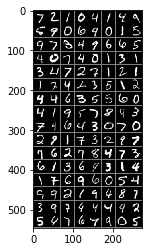

GroundTruth:      7     2     1     0


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [38]:
images = images.to(device)
outputs = net(images)

In [39]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


In [75]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted.to(device) == labels.to(device)).item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


In [74]:
print(labels.size(0))
torch.sum(predicted.to(device) == labels.to(device)).item()/total

128


0.296875

In [77]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted.to(device) == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 93 %
Accuracy of     2 : 87 %
Accuracy of     3 : 85 %
Accuracy of     4 : 85 %
Accuracy of     5 : 81 %
Accuracy of     6 : 82 %
Accuracy of     7 : 90 %
Accuracy of     8 : 86 %
Accuracy of     9 : 94 %
